In [12]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['figure.dpi'] = 300

In [2]:
def checkerboard(height, width, r=False):
    """
    Takes in the dimensions of the checkerboard mask to be produced.
    Will output a 2D tf tensor containing a checkerboard pattern of 1s and 0s.
    """
    checkerboard = [[(i + j) % 2 for j in range(width)] for i in range(height)]
    return tf.convert_to_tensor(checkerboard, dtype='float32')

In [3]:
class RNVP(tf.keras.Model):
    def __init__(self, depth, height, prior_dim, hidden_size):
        super(RNVP, self).__init__()

        """
        Takes in the depth of each component network in the Model (depth) as well as the dimension of the density we're estimating (prior_dim).
        The structure of the Model has four main components, the mask, the prior, the t-network and the s-network.
        In init we construct each of these according to the specifications described by height, depth and prior_dim
        
        Inputs:
          depth: number of layers in each network of s and t
          height: number of transformations (ie, height of mask/ number of networks in s and t)
          prior_dim: dimension size of input data points 
          hidden_size: number of nodes in each of the hidden layers
        """
        ## Construct prior
        ## We assume for simplicity the prior is a MVN of the same dimension as the input data
        self.prior = tfp.distributions.MultivariateNormalTriL(loc=tf.zeros(prior_dim), scale_tril=tf.eye(prior_dim))
        ## Construct mask
        self.height = height 
        self.mask = checkerboard(self.height,prior_dim)
        ## Initialize t and s network lists
        ## The number of networks in the list should be the same as the number of rows in mask
        ## Each network should have number of layers = depth, the last layer in each s network should have tanh activation
        self.t = []
        self.s = []
        for i in range (self.height):
          self.t.append(Sequential())
          self.s.append(Sequential())
        self.hidden_size = hidden_size
        ## Fill each network in both network lists
        for j in range(self.height):
            for i in range(depth-1):
                self.t[j].add(Dense(
                    self.hidden_size,
                    activation= tf.keras.layers.LeakyReLU(alpha=0.01),
                    kernel_initializer= 'uniform',
                    bias_initializer= 'uniform'))
                self.s[j].add(Dense(
                    self.hidden_size,
                    activation= tf.keras.layers.LeakyReLU(alpha=0.01),
                    kernel_initializer= 'uniform',
                    bias_initializer= 'uniform'))
            self.t[j].add(Dense(
                prior_dim,
                kernel_initializer= 'uniform',
                bias_initializer= 'uniform'))
            self.s[j].add(Dense(
                prior_dim,
                activation='tanh',
                kernel_initializer= 'uniform',
                bias_initializer= 'uniform'))


    def call(self, x):
        """
        When the layers have been fully learned, this call will transform data from an arbitrary
        distribution to data from a multivariate normal distribution in an invertible way 

        Inputs:
            x: A sample distribution of size (num_samples x prior_dim)
        Returns:
            output_dist: forward transform of x, what the original distribution looks like in the latent space (prior distribution)
            sldj: the log determinant of the Jacobian for the s network layers
        """
        ## Initialize our output_dist as our input_dist x, we will iteratively update it until it looks normal
        output_dist = x
        num_samples = x.shape[0]
        sldj = tf.zeros([num_samples])
        ## Loop through each row in the mask and each network in t and s 
        for i in range(self.height):
            ## Mask and reverse mask will each be of shape (prior_dim)
            mask = self.mask[i]
            reverse_mask = 1 - mask
            ## The variables s and t in the loop will be networks with number of layers = depth
            s = self.s[i]
            t = self.t[i]
            ## First apply the forward mask to output_dist
            ## output_dist_masked will have the same shape as output_dist (num_samples x prior_dim)
            output_dist_masked = mask * output_dist
            ## Pass this through s and t and subsequently apply reverse mask
            ## s_out and t_out will be of size (num_samples x prior_dim)
            s_out = s(output_dist_masked)* reverse_mask
            t_out = t(output_dist_masked)* reverse_mask
            ## Update output_dist via the transformation described in equation (8) of this paper https://arxiv.org/pdf/1605.08803.pdf
            ## We add the un-updated output_dist_masked to the updated output_dist multiplied by the reverse mask 
            updated_dist = (output_dist-t_out) * tf.math.exp(-1 * s_out)
            output_dist = output_dist_masked + reverse_mask * updated_dist
            ## We also update the log of the determinant of the Jacobian at each step of the transformation according
            ## to equation (6) from the same paper. Note we are subtracting away instead of adding because we are looking at the reverse transformation
            ## of the one described in the paper. We still want to maximize this sldj value even though it's negative
            sldj -= tf.math.reduce_sum(s_out, axis=1)

        return output_dist, sldj


    def loss_function(self, output_dist, sldj):
        """
        By the change of variable theory, computing the density on a point x is accomplished by
        computing the density of its image f(x) and multiplying by the associated Jacobian determinant
        of the transformation (3) | we can thus define our negative log likelihood (which we hope to minimize)
        as the average of our sldj output subtracted out from the negative prior log probability of the output distribution

        Inputs:
            output_dist: latent space distribution 
            sldj: negative log of the determinant of the jacobian of the transformation 
        Returns:
            loss: average negative log likelihood as described above
        """
        ## Negative prior log probability of the output distribution
        npp = -self.prior.log_prob(output_dist)
        ## Subtract out log determinant of jacobian 
        nlls = npp - sldj
        ## Average and return

        return tf.reduce_mean(nlls)

  
    def sample (self, num_samples):
      """
        This function performs the inverse operation of call, so that once the transformation layers
        have been fully learned you will be able to generate num_samples data points from the prior 
        (via simple sampling) and then transform those points to the desired distribution we've learned
        This offers a quick and efficient way of sampling from arbitrarily complex distributions so long as they've been
        learned by the model.  

        Inputs:
            num_samples: the number of sample points you want to generate
        Returns:
            input_dist: a sampled distribution of points from the input space of size num_samples
        """
      ## Randomly sample from prior
      input_dist = self.prior.sample([num_samples])
      ## Run inverse transformation (ie do the steps in call but backwards)
      for i in reversed(range(self.height)):
        ## Mask and reverse mask will each be of shape (prior_dim)
        mask = self.mask[i]
        reverse_mask = 1 - mask
        ## The variables s and t in the loop will be networks with number of layers = depth
        s = self.s[i]
        t = self.t[i]
        ## First apply the forward mask to input_dist
        input_dist_masked = mask * input_dist
        ## Pass this through s and t and subsequently apply reverse mask
        s_out = s(input_dist_masked)* reverse_mask
        t_out = t(input_dist_masked)* reverse_mask
        ## Update input_dist via the transformation described in equation (7) of this paper https://arxiv.org/pdf/1605.08803.pdf
        input_dist = input_dist_masked + reverse_mask * (t_out + input_dist * tf.math.exp(s_out))

      return input_dist

In [4]:
flow = RNVP(depth = 3, height = 6, prior_dim = 2, hidden_size = 256)

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
for t in range(5001):   
    moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    with tf.GradientTape() as tape:
      z, sldj = flow.call(tf.convert_to_tensor(moons))
      loss = flow.loss_function(z, sldj)
    gradients = tape.gradient(loss, flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients, flow.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.541
iter 200: loss = 1.588
iter 400: loss = 0.995
iter 600: loss = 0.860
iter 800: loss = 0.797
iter 1000: loss = 0.679
iter 1200: loss = 0.577
iter 1400: loss = 0.600
iter 1600: loss = 0.521
iter 1800: loss = 0.494
iter 2000: loss = 0.801
iter 2200: loss = 0.545
iter 2400: loss = 0.522
iter 2600: loss = 0.459
iter 2800: loss = 0.517
iter 3000: loss = 0.508
iter 3200: loss = 0.568
iter 3400: loss = 0.451
iter 3600: loss = 0.496
iter 3800: loss = 0.470
iter 4000: loss = 0.505
iter 4200: loss = 0.619
iter 4400: loss = 0.425
iter 4600: loss = 0.516
iter 4800: loss = 0.488
iter 5000: loss = 0.567


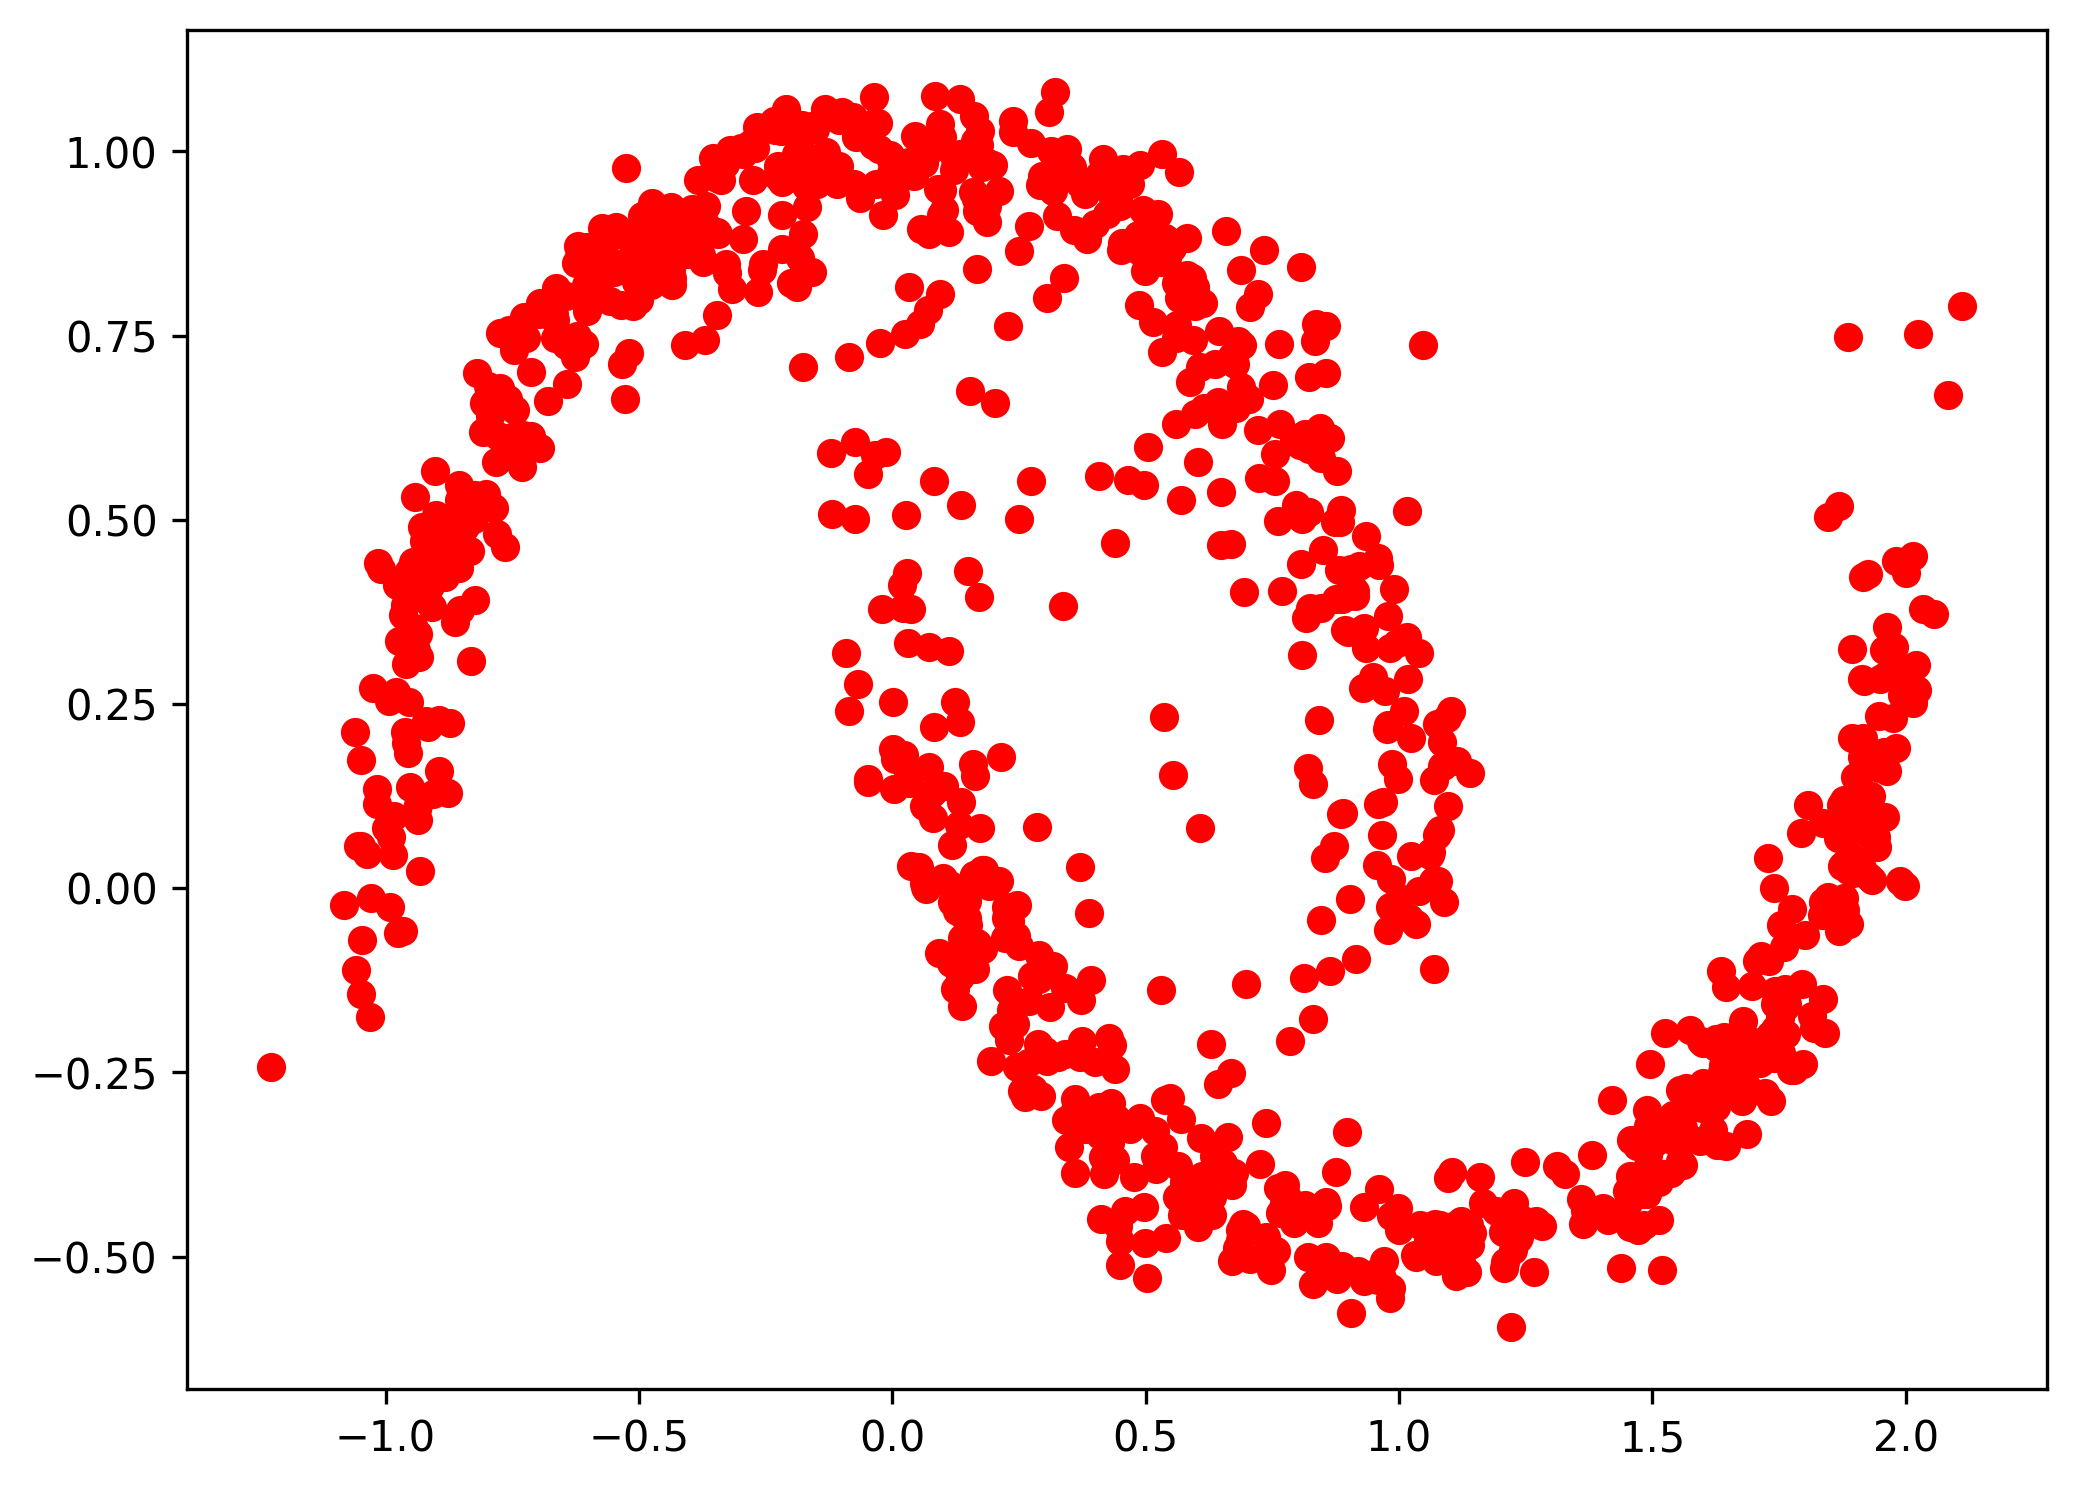

In [13]:
x = flow.sample(1000).numpy()
plt.scatter(x[:,0],x[:,1], c='r')
plt.show()


In [7]:
flow2 = RNVP(depth = 8, height = 6, prior_dim = 784, hidden_size = 512)

In [8]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = np.reshape(train_images, [train_images.shape[0], -1])
test_images = np.reshape(test_images, [test_images.shape[0],-1])
train_images = train_images / 255.0
test_images = test_images / 255.0

images = np.concatenate((train_images,test_images),axis=0)
images = tf.convert_to_tensor(images,dtype='float32')

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
for t in range(5001):   
    indices = np.random.choice(70000,100,replace=False)
    batch_of_digits = tf.gather(images,indices)
    with tf.GradientTape() as tape:
      z, sldj = flow2.call(batch_of_digits)
      loss = flow2.loss_function(z, sldj)
    gradients = tape.gradient(loss, flow2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, flow2.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 766.867
iter 200: loss = -709.743
iter 400: loss = -802.216
iter 600: loss = -912.342
iter 800: loss = -957.363
iter 1000: loss = -1019.522
iter 1200: loss = -1037.959
iter 1400: loss = -1051.343
iter 1600: loss = -1088.137
iter 1800: loss = -1099.923
iter 2000: loss = -1080.199
iter 2200: loss = -1142.043
iter 2400: loss = -1110.673
iter 2600: loss = -1113.206
iter 2800: loss = -1092.090
iter 3000: loss = -1136.189
iter 3200: loss = -1160.224
iter 3400: loss = -1153.504
iter 3600: loss = -1146.540
iter 3800: loss = -1172.371
iter 4000: loss = -1139.528
iter 4200: loss = -1155.976
iter 4400: loss = -1179.265
iter 4600: loss = -1185.669
iter 4800: loss = -1192.891
iter 5000: loss = -1195.421


In [15]:
for t in range(5001):   
    indices = np.random.choice(70000,100,replace=False)
    batch_of_digits = tf.gather(images,indices)
    with tf.GradientTape() as tape:
      z, sldj = flow2.call(batch_of_digits)
      loss = flow2.loss_function(z, sldj)
    gradients = tape.gradient(loss, flow2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, flow2.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = -1196.710
iter 200: loss = -1191.056
iter 400: loss = -1188.248
iter 600: loss = -1203.245
iter 800: loss = -1217.536
iter 1000: loss = -1226.576
iter 1200: loss = -1211.502
iter 1400: loss = -1223.412
iter 1600: loss = -1209.491
iter 1800: loss = -1262.672
iter 2000: loss = -1250.149
iter 2200: loss = -1234.148
iter 2400: loss = -1248.938
iter 2600: loss = -1235.699
iter 2800: loss = -1224.595
iter 3000: loss = -1249.438
iter 3200: loss = -1262.055
iter 3400: loss = -1247.661
iter 3600: loss = -1255.681
iter 3800: loss = -1252.610
iter 4000: loss = -1274.690
iter 4200: loss = -1252.765
iter 4400: loss = -1240.230
iter 4600: loss = -1280.179
iter 4800: loss = -1295.880
iter 5000: loss = -1266.505


In [16]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap='gray')
    return

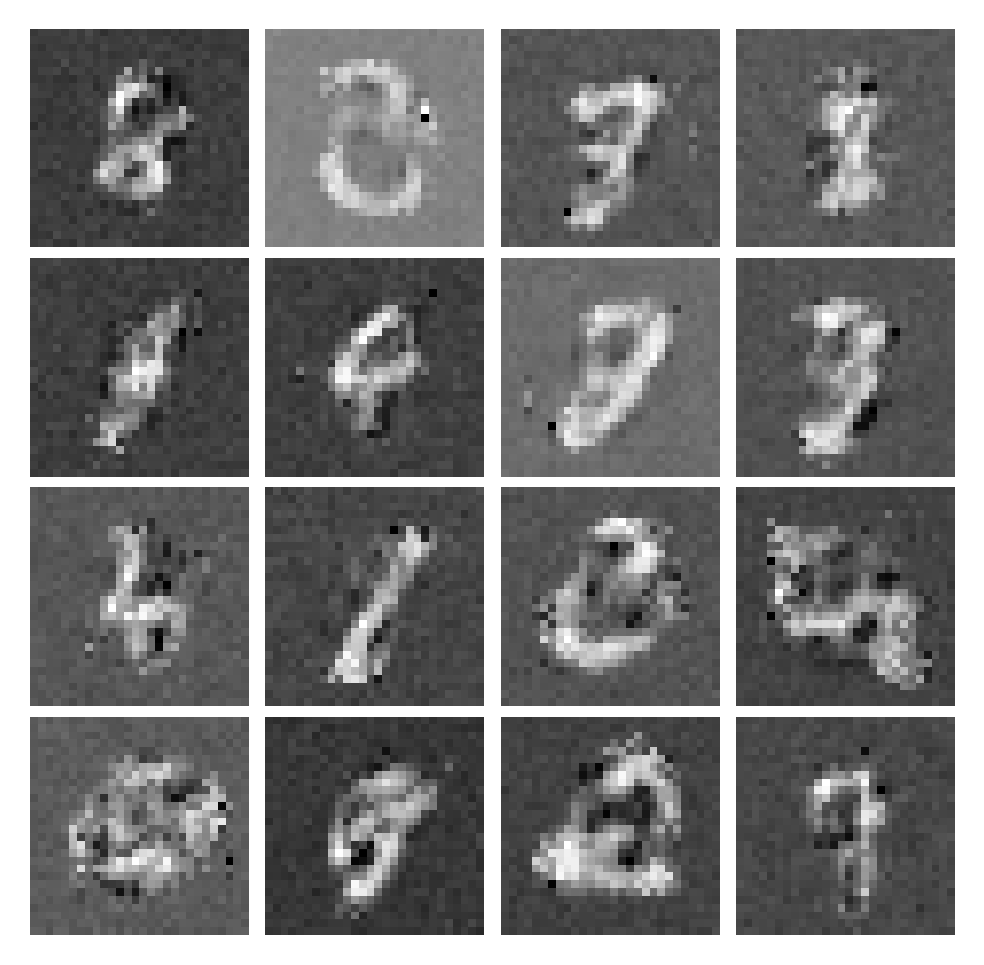

In [68]:
x = tf.nn.sigmoid(flow2.sample(16))
show_images(x)